# Train a new CNN 

### Imports

In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
import random
import time

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow import keras

from tensorflow.python.keras.models import Sequential,Input,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout

2022-08-03 15:22:09.682981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vigitia/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib:/home/vigitia/ros2_galactic/ros2-linux/opt/yaml_cpp_vendor/lib:/home/vigitia/ros2_galactic/ros2-linux/opt/rviz_ogre_vendor/lib:/home/vigitia/ros2_galactic/ros2-linux/lib
2022-08-03 15:22:09.682997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Constants

In [2]:
IMG_SIZE = 48
MIN_BRIGHTNESS_PREDICTION = 50

PARENT_DIRECTORY = '../out3/'
FOLDER_NAME = '2022-08-02'

In [3]:
DRAW_PATHS = []
HOVER_PATHS = []

target_folder = os.path.join(PARENT_DIRECTORY, FOLDER_NAME)

subfolders = (next(os.walk(target_folder))[1])

for subfolder_name in subfolders:
    if 'draw' in subfolder_name:
        DRAW_PATHS.append(os.path.join(PARENT_DIRECTORY, FOLDER_NAME, subfolder_name))
    elif 'hover' in subfolder_name:
        HOVER_PATHS.append(os.path.join(PARENT_DIRECTORY, FOLDER_NAME, subfolder_name))
    else:
        print('ERROR: Malformed folder name')
        
print('All folders with "DRAW"  images: ', DRAW_PATHS)
print('All folders with "HOVER" images: ', HOVER_PATHS)

ERROR: Malformed folder name
All folders with "DRAW"  images:  ['../out3/2022-08-02/draw_1_400_18', '../out3/2022-08-02/draw_4_400_18', '../out3/2022-08-02/draw_3_400_18', '../out3/2022-08-02/draw_2_400_18', '../out3/2022-08-02/draw_0_400_18']
All folders with "HOVER" images:  ['../out3/2022-08-02/hover_far_3_400_18', '../out3/2022-08-02/hover_far_0_400_18', '../out3/2022-08-02/hover_far_1_400_18', '../out3/2022-08-02/hover_far_2_400_18', '../out3/2022-08-02/hover_close_3_400_18', '../out3/2022-08-02/hover_close_1_400_18', '../out3/2022-08-02/hover_close_0_400_18']


### Helper functions

In [4]:
def read_images_mono(path):
    
    files = os.listdir(path)
    files = [file for file in files if file[-4:] == ".png"]
    
    print('Read {} files from "{}"'.format(len(files), path))
    
    images = []
    coords = []
    
    size = IMG_SIZE
    
    skip_count = 0
    
    for file in tqdm(files):
        try:
            image = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
            if image.shape == (size, size) and np.max(image) > MIN_BRIGHTNESS_PREDICTION and '681_597' not in file and '46_565' not in file:
                images.append(image)
            else:
                # print(image.shape, np.max(image))
                skip_count += 1
            
        except OSError:
            pass
    
    print('Skipped:', skip_count)
    return images, coords

In [5]:
def data_augmentation(images):
    result = []
    for img in images:
        result.append(img)
        result.append(cv2.flip(img, flipCode=0))
        for i in range(3):  # TODO: CHECK IF 4 is needed here
            tmp = cv2.rotate(img, i)
            for b in range(10, 11):
                tmp2 = np.clip(tmp * (b / 10), 0, 255)
                result.append(tmp2)
                result.append(cv2.flip(tmp2, flipCode=0))
    return result

### Read in images and create additional images via Data Augmentation

In [6]:
images_draw = []
images_hover = []

for p in DRAW_PATHS:
    images_draw += read_images_mono(p)[0]
    
for p in HOVER_PATHS:
    images_hover += read_images_mono(p)[0]

images_draw = data_augmentation(images_draw)
images_hover = data_augmentation(images_hover)
images = images_draw + images_hover
labels = [0] * len(images_draw) + [1] * len(images_hover)

print(len(images_hover))
print(len(images_draw))
print(len(images))
print(len(labels))

Read 3000 files from "../out3/2022-08-02/draw_1_400_18"


/tmp/ipykernel_43179/513466372.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/3000 [00:00<?, ?it/s]

Skipped: 64
Read 3000 files from "../out3/2022-08-02/draw_4_400_18"


  0%|          | 0/3000 [00:00<?, ?it/s]

Skipped: 1
Read 3000 files from "../out3/2022-08-02/draw_3_400_18"


  0%|          | 0/3000 [00:00<?, ?it/s]

Skipped: 0
Read 3000 files from "../out3/2022-08-02/draw_2_400_18"


  0%|          | 0/3000 [00:00<?, ?it/s]

Skipped: 0
Read 5613 files from "../out3/2022-08-02/draw_0_400_18"


  0%|          | 0/5613 [00:00<?, ?it/s]

Skipped: 2592
Read 3000 files from "../out3/2022-08-02/hover_far_3_400_18"


  0%|          | 0/3000 [00:00<?, ?it/s]

Skipped: 0
Read 3000 files from "../out3/2022-08-02/hover_far_0_400_18"


  0%|          | 0/3000 [00:00<?, ?it/s]

Skipped: 962
Read 3000 files from "../out3/2022-08-02/hover_far_1_400_18"


  0%|          | 0/3000 [00:00<?, ?it/s]

Skipped: 18
Read 3000 files from "../out3/2022-08-02/hover_far_2_400_18"


  0%|          | 0/3000 [00:00<?, ?it/s]

Skipped: 0
Read 3000 files from "../out3/2022-08-02/hover_close_3_400_18"


  0%|          | 0/3000 [00:00<?, ?it/s]

Skipped: 0
Read 3000 files from "../out3/2022-08-02/hover_close_1_400_18"


  0%|          | 0/3000 [00:00<?, ?it/s]

Skipped: 38
Read 3000 files from "../out3/2022-08-02/hover_close_0_400_18"


  0%|          | 0/3000 [00:00<?, ?it/s]

Skipped: 2163
142552
119648
262200
262200


52460 262200
0


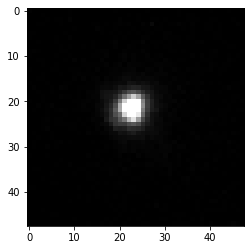

In [7]:
randi = random.randint(0, len(images))
print(randi, len(images))
print(labels[randi])
plt.imshow(images[randi], 'gray')

### Preview Data

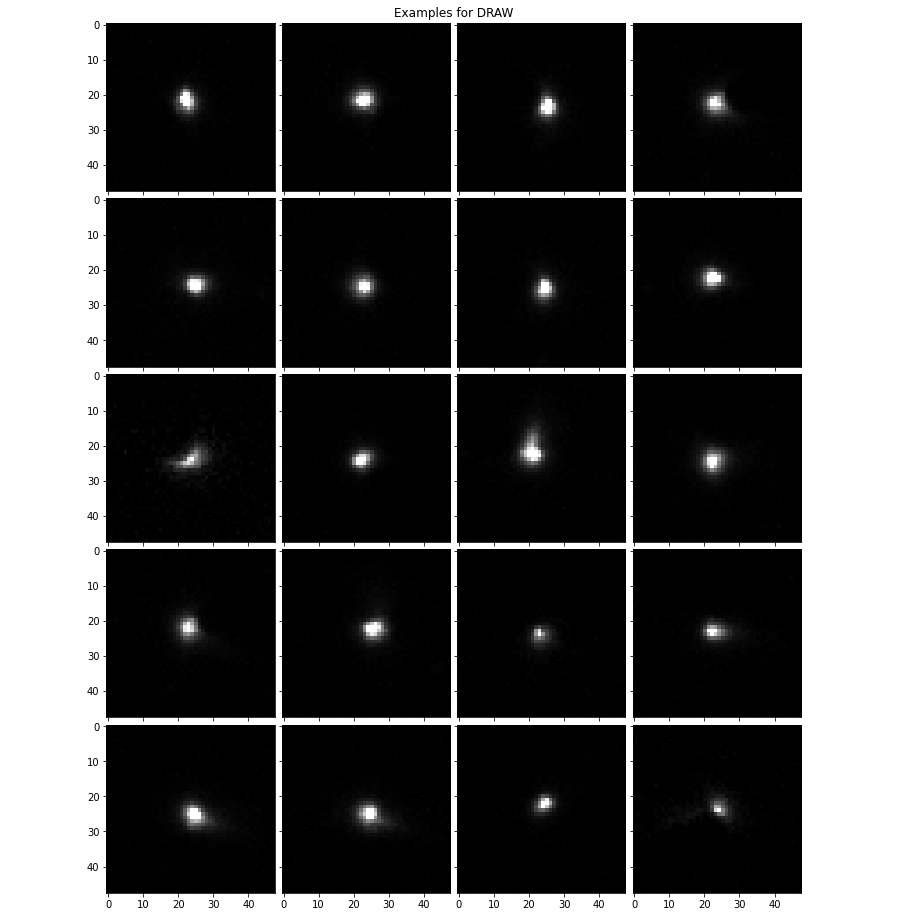

In [8]:
ROWS = 4
COLUMS = 5


image_list = []
for i in range(ROWS*COLUMS):
    image_list.append(random.sample(images_draw, 1)[0])


fig = plt.figure(figsize=(16, 16))
plt.title('Examples for DRAW')
plt.axis('off')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(COLUMS, ROWS),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, image_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, 'gray')

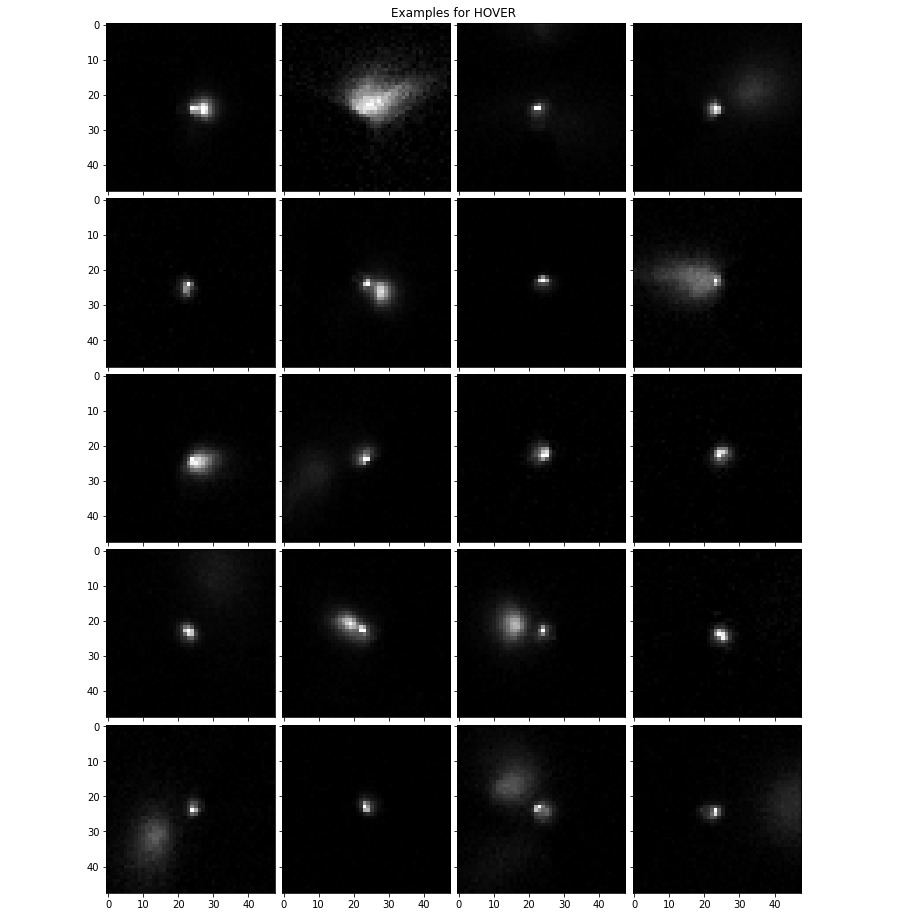

In [9]:
ROWS = 4
COLUMS = 5


image_list = []
for i in range(ROWS*COLUMS):
    image_list.append(random.sample(images_hover, 1)[0])


fig = plt.figure(figsize=(16, 16))
plt.title('Examples for HOVER')
plt.axis('off')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(COLUMS, ROWS),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, image_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, 'gray')

### Prepare Training and Validation Data

In [10]:
train_X = np.array(images)
train_Y = np.array(labels)

print('Training data shape : ', train_X.shape, train_Y.shape)

train_X = train_X.astype('float32')
train_X = train_X / 255.

train_Y_one_hot = to_categorical(train_Y)

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.1, random_state=13)

train_X = train_X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print(train_X.shape, valid_X.shape, train_label.shape, valid_label.shape)

unique, counts = np.unique(valid_label, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(train_label, return_counts=True)

print(dict(zip(unique, counts)))

Training data shape :  (262200, 48, 48) (262200,)
(235980, 48, 48, 1) (26220, 48, 48) (235980, 2) (26220, 2)
{0.0: 26220, 1.0: 26220}
{0.0: 235980, 1.0: 235980}


In [12]:
l = [0, 0]
for i in valid_label:
    #print(i)
    l[int(np.argmax(i))] += 1
l

[11989, 14231]

### Start Training

In [16]:
#Settings

# batch 64
# epoch 1
# conv linear

batch_size = 256
epochs = 3
num_classes = 2
activation = 'relu'
activation_conv = 'linear'
layer_count = 5
num_neurons = 128

#for epochs in range(1, 7):
    #print(f'+++++ EPOCHS: {epochs} +++++')
#Define model structure
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 1),activation=activation_conv,input_shape=(IMG_SIZE,IMG_SIZE,1),padding='same'))
model.add(Conv2D(64, (1, 3), activation=activation_conv,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(32, (3, 1), activation=activation_conv,padding='same'))
model.add(Conv2D(32, (1, 3), activation=activation_conv,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(32, (3, 3), activation=activation_conv,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.2))
#model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))                 
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())

# trial and error: linear performs much better than ReLU and sigmoid
for i in range(layer_count-1):
    model.add(Dense(num_neurons, activation=activation))
model.add(Dropout(0.2))
model.add(Dense(num_neurons, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(128, activation='linear'))
#model.add(Dense(128, activation='linear'))

# classifier
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.metrics.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

Epoch 1/3
922/922 [==============================] - 323s 350ms/step - loss: 0.1806 - accuracy: 0.9322 - val_loss: 0.0849 - val_accuracy: 0.9717
Epoch 2/3
922/922 [==============================] - 337s 366ms/step - loss: 0.0814 - accuracy: 0.9733 - val_loss: 0.0499 - val_accuracy: 0.9839
Epoch 3/3
922/922 [==============================] - 341s 369ms/step - loss: 0.0522 - accuracy: 0.9832 - val_loss: 0.0413 - val_accuracy: 0.9862


In [23]:
history = model.fit(
    train_X, 
    train_label, 
    batch_size=batch_size,
    epochs=2,
    verbose=1,
    validation_data=(valid_X, valid_label),
    callbacks=[reduce_lr]
)

Epoch 1/2
922/922 [==============================] - 325s 353ms/step - loss: 0.0278 - accuracy: 0.9914 - val_loss: 0.0251 - val_accuracy: 0.9928
Epoch 2/2
922/922 [==============================] - 343s 372ms/step - loss: 0.0227 - accuracy: 0.9929 - val_loss: 0.0138 - val_accuracy: 0.9955


In [24]:
# TODO: Create a plot from these values
loss = print(history.history['loss'])
val_loss = print(history.history['val_loss'])
accuracy = print(history.history['accuracy'])
val_accuracy = print(history.history['val_accuracy'])

[0.02779465541243553, 0.022669019177556038]
[0.025052398443222046, 0.0138150779530406]
[0.9913890957832336, 0.9928934574127197]
[0.9928299188613892, 0.9954614639282227]


### Save the Model

In [25]:
MODEL_NAME = 'model_new_projector_9'

if MODEL_NAME in next(os.walk('.'))[1]:
    print('Warning: There already exists a model called "{}"'.format(MODEL_NAME))
    print('Make sure you want to overwrite it before it gets saved!')
else:
    model.save(MODEL_NAME)

INFO:tensorflow:Assets written to: model_new_projector_9/assets


INFO:tensorflow:Assets written to: model_new_projector_9/assets



---------------------------------------------


In [246]:
model = keras.models.load_model('model_new_projector_4')


1/1 [==============================] - 0s 12ms/step
[[0. 1.]]
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 10ms/step
[[0. 1.]]
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
--
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 14ms/step
[[0. 1.]]
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 10ms/step
[[0. 1.]]
--
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 10ms/step
[[0. 1.]]
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
--
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 10ms/step
[[0. 1.]]
1/1 [==============================] - 0s 10ms/step
[[0. 1.]]
1/1 [==============================] - 0s 14ms/step
[[0. 1.]]

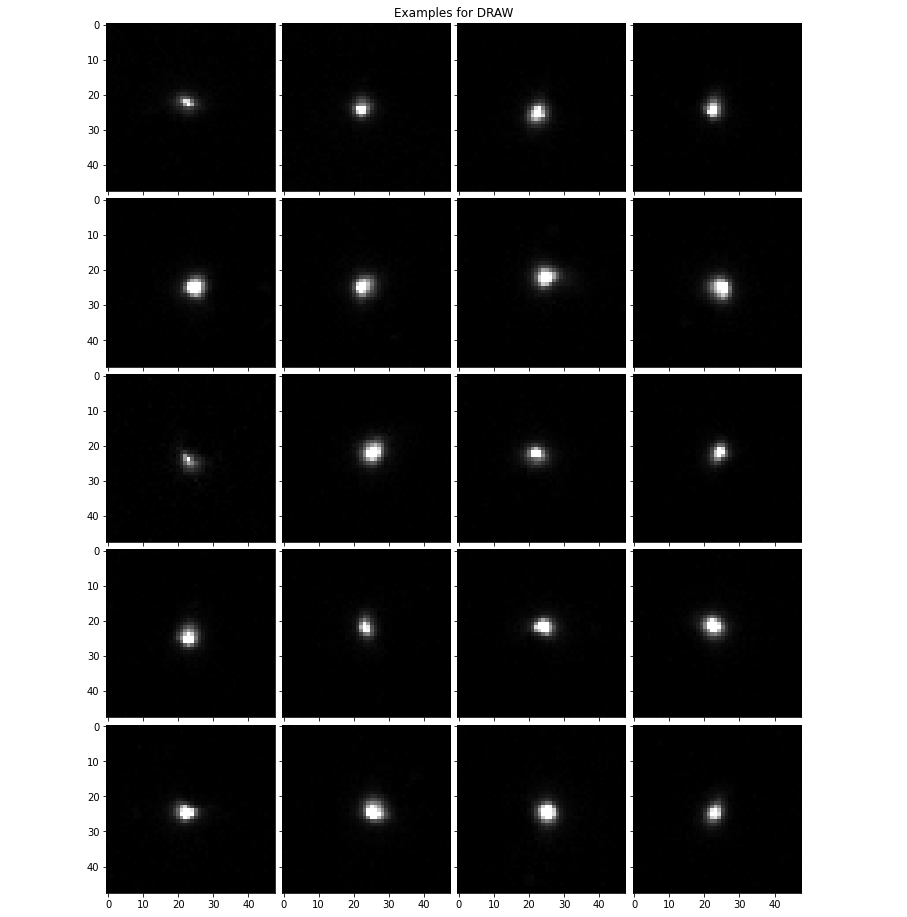

In [248]:
ROWS = 4
COLUMS = 5


image_list = []
for i in range(ROWS*COLUMS):
    image_list.append(random.sample(images_draw, 1)[0])


for i, image in enumerate(image_list):
    prediction = model.predict(image.reshape(-1, IMG_SIZE, IMG_SIZE, 1))
    print(prediction)
    if (i + 1) % 4 == 0:
        print('--')
    

fig = plt.figure(figsize=(16, 16))
plt.title('Examples for DRAW')
plt.axis('off')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(COLUMS, ROWS),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, image_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, 'gray')

In [ ]:
import cv2
import os
import random
from matplotlib import pyplot as plt

STATES = ['draw', 'hover', 'undefined']

MODEL_PATH = 'model_new_projector_4'
keras.backend.clear_session()
#keras_lite_model = LiteModel.from_keras_model(keras.models.load_model(MODEL_PATH))
keras_lite_model = keras.models.load_model(MODEL_PATH)
print(os.getcwd())
draw_path = '../out3/2022-08-02/draw_1_400_18/'
image_paths_draw = os.listdir(draw_path)
hover_path = 'out3/2022-08-02/hover_close_1_400_18/'
image_paths_hover = os.listdir(hover_path)
correct = 0
num_draw = 0
correct_draw = 0
num_hover = 0
correct_hover = 0
brightnesses = []

draw_path_temp = []
for filename in image_paths_draw:
    if '681_597' not in filename:
        draw_path_temp.append(filename)
    else:
        print('Oh no')

image_paths_draw = draw_path_temp

too_dark = 0
for image in image_paths_draw:
    img = cv2.imread(draw_path + random.sample(image_paths_draw, 1)[0], cv2.IMREAD_GRAYSCALE)
    brightnesses.append(np.max(img))
    if np.max(img) < 50:
        too_dark +=1

print('TOO DARK:', too_dark/len(image_paths_draw))

for i in range(1000):
    condition = 'hover' if int(random.random() * 1000) % 2 == 0 else 'draw'
    # condition = 'draw'
    if condition == 'draw':
        num_draw += 1
        img = cv2.imread(draw_path + random.sample(image_paths_draw, 1)[0], cv2.IMREAD_GRAYSCALE)
        # print('Max', np.max(img))
    else:
        num_hover += 1
        img = cv2.imread(hover_path + random.sample(image_paths_hover, 1)[0], cv2.IMREAD_GRAYSCALE)
    #cv2.imshow('test', img)
    #cv2.waitKey(0)
    img = img.reshape(-1, 48, 48, 1)
    print(condition)
    prediction = keras_lite_model.predict(img)
    print(prediction)
    state = STATES[np.argmax(prediction)]
    if condition == state:
        if condition == 'draw':
            correct_draw += 1
        if condition == 'hover':
            correct_hover += 1
        correct +=1
    # print(condition, state)
print('----')
print('Correct total:', correct, '%')
print('Correct Draw:', correct_draw, ' / ', num_draw) #int((correct_draw/num_draw)*100), '%')
print('Correct Hover:', correct_hover, ' / ', num_hover)  # int((correct_draw/num_draw)*100), '%')
plt.boxplot(brightnesses)#, np.ones(len(brightnesses), np.uint8))
plt.scatter(np.ones(len(brightnesses), np.uint8), brightnesses, alpha=0.2)
plt.show()
